# Music Genre Analysis: A Vector-Based Approach to Song Classification

#### This notebook presents a comprehensive analysis of music genre classification using keyword-based vectorization and clustering techniques. The approach leverages three key descriptors for each song - instrument, mood, and style - to group similar music pieces together.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#reading in the data

df = pd.read_csv('dataset.csv')
total = len(df) # number of documents for tf-idf (i.e. number of rows in our csv file)

print(df.head())

   song_id keyword_1  keyword_2  keyword_3      genre
0       74    guitar      happy  distorted       rock
1      103     brass  energetic    melodic  classical
2      201     banjo      happy   acoustic    country
3      194     synth  energetic      heavy    hip-hop
4      184     synth  energetic       slow    hip-hop


In [3]:
# generating the vocabulary and also their total frequency in all documents

instrument_frequency = df.iloc[:, 1].value_counts()
mood_frequency = df.iloc[:, 2].value_counts()
style_frequency = df.iloc[:, 3].value_counts()

print(instrument_frequency, mood_frequency, style_frequency, sep='\n\n')

keyword_1
guitar    65
synth     43
piano     12
brass     11
violin    10
banjo      6
Name: count, dtype: int64

keyword_2
happy        30
mellow       28
energetic    27
sad          21
angry        12
calm         11
emotional    11
upbeat        4
nostalgic     3
Name: count, dtype: int64

keyword_3
fast         28
melodic      27
slow         23
upbeat       20
rhythmic     14
heavy        10
acoustic      9
twangy        6
distorted     5
danceable     5
Name: count, dtype: int64


In [4]:
#assigning indices to each keyword

instrument_indices = {word: idx for idx, word in enumerate(instrument_frequency.index)}
mood_indices = {word: idx for idx, word in enumerate(mood_frequency.index)}
style_indices = {word: idx for idx, word in enumerate(style_frequency.index)}

print(instrument_indices, mood_indices, style_indices, sep='\n')

{'guitar': 0, 'synth': 1, 'piano': 2, 'brass': 3, 'violin': 4, 'banjo': 5}
{'happy': 0, 'mellow': 1, 'energetic': 2, 'sad': 3, 'angry': 4, 'calm': 5, 'emotional': 6, 'upbeat': 7, 'nostalgic': 8}
{'fast': 0, 'melodic': 1, 'slow': 2, 'upbeat': 3, 'rhythmic': 4, 'heavy': 5, 'acoustic': 6, 'twangy': 7, 'distorted': 8, 'danceable': 9}


## Methodology

### 1. Vector Generation

#### TF-IDF Approach
The chosen approach uses TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, 
which effectively captures the importance of keywords while accounting for their frequency 
across the dataset. This method was selected over Bag of Words (BoW) so that keywords 
which are just more common in music in general don't skew the analysis.

The vector values for each keyword are calculated using
vector_value = log(total_songs / keyword_frequency)

In [5]:
#generating vectors for each keyword for each song

instrument_vectorizations = {}
mood_vectorizations = {}
style_vectorizations = {}

for row in df.itertuples():
    instrument_vector = np.zeros(len(instrument_frequency))
    mood_vector = np.zeros(len(mood_frequency))
    style_vector = np.zeros(len(style_frequency))
    
    instrument_vector[instrument_indices[row.keyword_1]] = np.log(total / instrument_frequency[row.keyword_1])
    mood_vector[mood_indices[row.keyword_2]] = np.log(total / mood_frequency[row.keyword_2])
    style_vector[style_indices[row.keyword_3]] = np.log(total / style_frequency[row.keyword_3])
    
    instrument_vectorizations[row.song_id] = instrument_vector
    mood_vectorizations[row.song_id] = mood_vector
    style_vectorizations[row.song_id] = style_vector

for i, (key, value) in enumerate(instrument_vectorizations.items()):
    print(key, value)
    if i > 5:
        break

74 [0.81604532 0.         0.         0.         0.         0.        ]
103 [0.         0.         0.         2.59253731 0.         0.        ]
201 [0.         0.         0.         0.         0.         3.19867312]
194 [0.         1.22923247 0.         0.         0.         0.        ]
184 [0.         1.22923247 0.         0.         0.         0.        ]
97 [0.         0.         0.         2.59253731 0.         0.        ]
63 [0.81604532 0.         0.         0.         0.         0.        ]


### 2. Dimensionality Reduction
Principal Component Analysis (PCA) was applied to reduce the high-dimensional vectors 
to 2D representations while preserving the most important variations in the data. 
The process involved:
1. Centering the data by subtracting the mean
2. Computing the covariance matrix
3. Finding eigenvectors and eigenvalues
4. Selecting the top two principal components
5. Projecting the data onto the new 2D space

In [6]:
def pca(data):
    data_centered = data - np.mean(data, axis=0)
    
    covariance_matrix = np.cov(data_centered.T)
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    
    principal_components = eigenvectors_sorted[:, :2]
    
    return np.dot(data_centered, principal_components)

In [7]:
instrument_matrix = np.array(list(instrument_vectorizations.values()))
mood_matrix = np.array(list(mood_vectorizations.values()))
style_matrix = np.array(list(style_vectorizations.values()))

instrument_pca = pca(instrument_matrix)
mood_pca = pca(mood_matrix)
style_pca = pca(style_matrix)

instrument_pca_dict = {song_id: instrument_pca[i] for i, song_id in enumerate(instrument_vectorizations.keys())}
mood_pca_dict = {song_id: mood_pca[i] for i, song_id in enumerate(mood_vectorizations.keys())}
style_pca_dict = {song_id: style_pca[i] for i, song_id in enumerate(style_vectorizations.keys())}

for i, (key, value) in enumerate(instrument_pca_dict.items()):
    if i < 5:
        print(key, value)
    else:
        break

74 [0.03506235 0.0497977 ]
103 [ 1.25362612 -1.85824478]
201 [0.08233847 0.1265566 ]
194 [0.1123261  0.18214744]
184 [0.1123261  0.18214744]


### 3. Vector Combination
The three separate 2D vectors (instrument, mood, and style) were combined using a 
weighted mean approach:
- Instrument weight: 0.5
- Mood weight: 0.2
- Style weight: 0.3

These weights were chosen based on general observations:
- Instruments get the highest weight because they are fundamental to defining musical genres
- Style gets the second highest weight as it provides important context
- Mood gets the lowest weight as it's the most genre-agnostic feature


In [8]:
combined_vectorization = {}

for song_id in instrument_pca_dict:
    combined_vectorization[song_id] = 0.5 * instrument_pca_dict[song_id] + 0.2 * mood_pca_dict[song_id] + 0.3 * style_pca_dict[song_id]

for i, (key, value) in enumerate(combined_vectorization.items()):
    if i < 5:
        print(key, value)
    else:
        break

74 [-0.03321966 -0.02627188]
103 [ 0.48204415 -0.88782181]
201 [-0.01484192 -0.00452769]
194 [-0.05618802  0.31767416]
184 [-0.34717009  0.74881946]


### 4. Clustering Analysis
K-means clustering was implemented with k=5 clusters, chosen because there appeared 
to be 5 distinct regions judging by the plot.

In [9]:
def kmeans(data, k, max_iters=200):
    np.random.seed(0)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return labels

In [10]:
combined_matrix = np.array(list(combined_vectorization.values()))
song_ids = list(combined_vectorization.keys())

k = 5
labels = kmeans(combined_matrix, k)

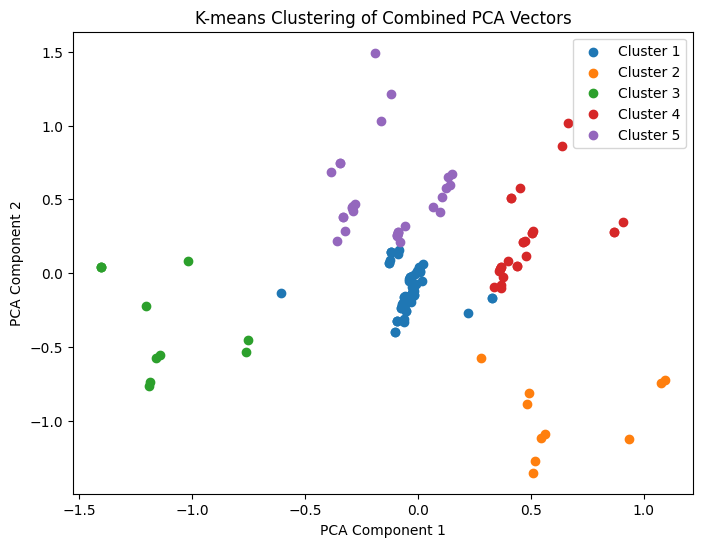

In [11]:
plt.figure(figsize=(8, 6))

for i in range(k):
    cluster_points = combined_matrix[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering of Combined PCA Vectors')
plt.legend()
plt.show()

In [12]:
#For analysis

genre = {}
for row in df.itertuples():
    genre[row[0]] = row.genre

for i in range(k):
    print(f"Cluster {i+1}:")
    songs = [genre[j] for j in range(len(labels)) if labels[j] == i]
    songs_dict = {}
    for song in songs:
        songs_dict[song] = songs_dict.get(song, 0) + 1
    print(songs_dict)

Cluster 1:
{'rock': 18, 'country': 15, 'pop': 20, 'hip-hop': 14, 'classical': 2}
Cluster 2:
{'classical': 10}
Cluster 3:
{'pop': 6, 'classical': 5}
Cluster 4:
{'country': 7, 'rock': 9, 'hip-hop': 9, 'classical': 2}
Cluster 5:
{'hip-hop': 7, 'classical': 8, 'country': 7, 'rock': 3, 'pop': 5}


### Cluster Interpretations:

**Cluster 1 (69 songs)** - Mixed/Largest Cluster
- Relatively even distribution among rock (26%), pop (29%), country (22%), and hip-hop (20%)
- Only 3% classical music
- This cluster seems too mixed, suggesting our features might not be discriminative enough

**Cluster 2 (10 songs)** - Pure Classical
- 100% classical music
- Most well-defined cluster
- Shows that classical music has some very distinctive features

**Cluster 3 (11 songs)** - Pop/Classical Mix
- 55% pop, 45% classical
- Small but interesting cluster showing similarity between some pop and classical pieces

**Cluster 4 (27 songs)** - Contemporary Mix
- Equal parts rock and hip-hop (33% each)
- 26% country, 7% classical
- Suggests shared characteristics among these contemporary genres

**Cluster 5 (30 songs)** - Even Distribution
- Most evenly distributed cluster
- Classical (27%), Country (23%), Hip-hop (23%), Pop (17%), Rock (10%)


### Silhouette Score

In [13]:
def calculate_silhouette_score(data, labels):
    n_samples = data.shape[0]
    n_clusters = len(np.unique(labels))
    silhouette_scores = np.zeros(n_samples)
    
    for i in range(n_samples):
        current_cluster = labels[i]
        
        same_cluster_points = data[labels == current_cluster]
        
        if len(same_cluster_points) > 1:
            a = np.mean(np.linalg.norm(data[i] - same_cluster_points, axis=1))
        else:
            a = 0
            
        b = float('inf')
        for cluster in range(n_clusters):
            if cluster != current_cluster:
                other_cluster_points = data[labels == cluster]
                mean_distance = np.mean(np.linalg.norm(data[i] - other_cluster_points, axis=1))
                b = min(b, mean_distance)
        
        if a == 0 and b == float('inf'):
            silhouette_scores[i] = 0
        else:
            silhouette_scores[i] = (b - a) / max(a, b)
    
    return np.mean(silhouette_scores)

mean_silhouette = calculate_silhouette_score(combined_matrix, labels)

print(f"\nClustering Quality Metrics:")
print(f"Mean Silhouette Score: {mean_silhouette:.3f}")


Clustering Quality Metrics:
Mean Silhouette Score: 0.547


## Genre Assignment for New Songs

Based on the analysis, we assign genres to new songs by plotting their locations 
on our plot using the embeddings we already found for each keyword and then 
assigning whichever cluster looks closest.

In [14]:
# Embeddings for each keyword

instrument_embeddings = {}
for keyword, idx in instrument_indices.items():
    songs_with_keyword = np.where(instrument_matrix[:, idx] > 0)[0]
    instrument_embeddings[keyword] = instrument_pca[songs_with_keyword[0]]
    
mood_embeddings = {}
for keyword, idx in mood_indices.items():
    songs_with_keyword = np.where(mood_matrix[:, idx] > 0)[0]
    mood_embeddings[keyword] = mood_pca[songs_with_keyword[0]]
    
style_embeddings = {}
for keyword, idx in style_indices.items():
    songs_with_keyword = np.where(style_matrix[:, idx] > 0)[0]
    style_embeddings[keyword] = style_pca[songs_with_keyword[0]]

print(instrument_embeddings, mood_embeddings, style_embeddings, sep='\n')

{'guitar': array([0.03506235, 0.0497977 ]), 'synth': array([0.1123261 , 0.18214744]), 'piano': array([-2.14116855, -0.67622441]), 'brass': array([ 1.25362612, -1.85824478]), 'violin': array([0.43010296, 1.67268557]), 'banjo': array([0.08233847, 0.1265566 ])}
{'happy': array([-0.23524469, -0.20271948]), 'mellow': array([-0.37309499, -1.01101267]), 'energetic': array([-0.50426699,  1.31305265]), 'sad': array([1.76780907, 0.13963524]), 'angry': array([-0.20772902, -0.15755967]), 'calm': array([-0.15126667, -0.09209138]), 'emotional': array([-0.15126667, -0.09209138]), 'upbeat': array([-0.02869312, -0.0122292 ]), 'nostalgic': array([-0.02313135, -0.00972637])}
{'fast': array([-0.11354889, -0.48286   ]), 'melodic': array([-0.14638506, -0.73769983]), 'slow': array([-1.00826581,  1.31711739]), 'upbeat': array([1.65531064, 0.74782995]), 'rhythmic': array([-0.13695606, -0.65535483]), 'heavy': array([-0.03832557, -0.12003363]), 'acoustic': array([-0.02987404, -0.09087365]), 'twangy': array([-0.0

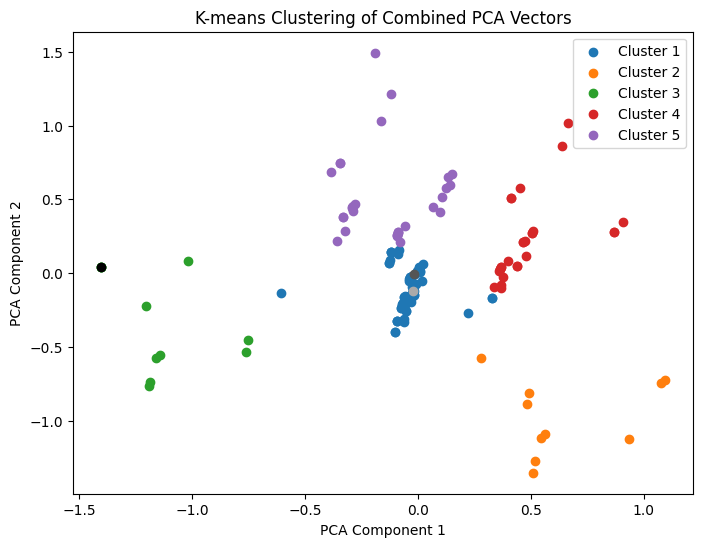

In [15]:
# [piano, calm, slow]
point1 = 0.5 * instrument_embeddings['piano'] + 0.2 * mood_embeddings['calm'] + 0.3 * style_embeddings['slow']
# [guitar, emotional, destorted]
point2 = 0.5 * instrument_embeddings['guitar'] + 0.2 * mood_embeddings['emotional'] + 0.3 * style_embeddings['distorted']
# [synth, mellow, distorted]
point3 = 0.5 * instrument_embeddings['synth'] + 0.2 * mood_embeddings['mellow'] + 0.3 * style_embeddings['distorted']

plt.figure(figsize=(8, 6))

for i in range(k):
    cluster_points = combined_matrix[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering of Combined PCA Vectors')
plt.legend()

plt.scatter(point1[0], point1[1], c='#000')
plt.scatter(point2[0], point2[1], c='#555')
plt.scatter(point3[0], point3[1], c='#AAA')

plt.show()

## Conclusions

The analysis demonstrates that keyword-based vectorization combined with dimensionality 
reduction and clustering can effectively group songs by genre. Although in our particular 
analysis, there seems to be significant overlaps which means it is not that accurate.

### Future Improvements Could Include:
- Integration of additional musical features
- Dynamic weight adjustment based on keyword importance
- Better techniques to combine embeddings
- More data
- Hierarchical clustering for sub-genre identification

### Key Findings:
1. Classical music forms the most distinct cluster
2. Contemporary genres (rock, pop, hip-hop, country) show more overlap
3. The weighted combination of instrument, mood, and style features provides 
   reasonable clustering results
4. The Silhouette Score of 0.547 indicates reasonably well-defined clusters